# Speed of Falling Human as Function of Altitude
## In response to Kyle's "How to Fall from ANY HEIGHT and Survive" video

Consider a skydiver falling from the "edge of space", which we will use as the von Karman line at 100km. We will assume he is falling head first and stays perpendicular to the earth for the entirity of his flight. From this altitude the air density is much less, allowing the skydiver to go well into the supersonic regime. So how does the mach number of the skydiver change as they fall through the atmosphere?

This approach will utilize an iteration approach and time-step through the fall. To calculate the height at a point in time after a given time step, $\Delta t$, the following equation can be used:
$$ h_\text{new} = h_\text{old} - u \Delta t $$
where $h$ is the height or altitude and $u$ is the velocity of the skydiver at that point in time. To calculate the speed at that time, we can use:
$$ u_\text{new} = u_\text{old} + F/m $$
Where $F$ is the total force on the skydiver and $m$ is the mass of the skydiver. The total force on the skydiver is calculated as:
$$ F = mg - F_D $$
where $g$ is the acceleration of gravity and $F_D$ is the drag force. The drag force is a bit more involved to calculate and is discussed in the next section.

## Calculating Drag
If we can approximate the skydiver as an airfoil, then we can calculate the total drag coefficient and thus the drag force on the skydiver.
[Drag at Supersonic Speeds](https://en.wikipedia.org/wiki/Supersonic_airfoils#Lift_and_drag):
$$ C_D = C_{D, \text{friction}} + C_{D, \text{thickness}} + C_{D, \text{lift}} $$
The $C_{D, \text{thickness}}$ is the coefficient of drag due to the "thickness" of the body, in this case referring to the wake drag, $C_{D,w}$. Experimentally, this expression is reduced to:
$$ C_D = C_{D, O} + kC_L^2 $$
Where $C_L$ is the coefficient of lift and $C_{D, O}=C_{D,f} + C_{D,w}$. If we assume no lift and thus no angle of attack, our overall drag coefficient reduces to:
$$ C_D = C_{D,f} + C_{D,w} $$
Where $C_{D,f}$ is the traditional drag coefficient due to friction. If we assume that the skydiver can be approximated as a "flat plate", then we can use the [following formulation](https://en.wikipedia.org/wiki/Wave_drag) for $C_{D,w}$:
$$ C_{D,w} = 4 \frac{\alpha^2}{\sqrt{M^2 - 1}} $$
Where $\alpha$ is the angle of attack and $M$ is the mach number. This formulation is also supported by this [NASA report](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19930082018.pdf) on pages 12 and 23. Since we are assuming no angle of attack, this coefficient conveniently drops, leaving the overall drag equal to the friction drag. In reality, there will be some form of wake drag, however this will be ignored for simplicity.

We can use the standard form of the drag coefficient that encompases both the frictional drag as well as form/pressure drag. The validity of this equation in the transsonic and supersonic regimes is questionable even under the current assumptions but will be used for simplicity. [This form is given as](https://en.wikipedia.org/wiki/Drag_coefficient):
$$ C_D = \frac{2F_d}{\rho u^2 A} $$
where $F_d$ is the force of drag, $\rho$ is the density of air calculated below, $u$ is the velocity, and $A$ is the cross-sectional area of the body. For this calculation, we will use the values [given in this article](https://en.wikipedia.org/wiki/Speed_skydiving) for a head-down position:
$$ C_D = 0.7,~A = 0.18~\text{m}^2,~m = 90~\text{kg} $$
It is important to note that the drag coefficient changes as a function of Reynolds number, which will change throughout this flight, but will be kept constant for simplicity.

## Calculating Density
From this [NASA Atmospheric Model](https://www.grc.nasa.gov/www/k-12/airplane/atmosmet.html), Density of air as a function of altitude:
$$\rho = \frac{p(h)}{.2869 (T(h) + 273.1)} $$
where $\rho$ is the density of air in kg/m^3, $p$ is the ambient pressure in kPa, $T$ is the temperature in Celcius, and $h$ is the altitude in meters.

For h < 11000:
$$ p(h) = 101.29 \left[\frac{T + 273.1}{288.08}\right]^{5.256} $$
$$ T(h) = 15.04 - 0.00649 h $$

For 11000 < h < 25000
$$ T(h) = -56.46 $$
$$ p(h) = 22.65 e^{1.73 - 0.000157h} $$

For h > 25000:
$$ T(h) = -131.21 + .00299 h $$
$$ p(h) = 2.488 \left[\frac{T + 273.1}{216.6}\right]^{-11.388} $$



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize parameters
h = 100000 #height, meters
m = 90 #mass of skydiver, kg
g = 9.81 #accel. of gravity, m/s^2
C_D = 0.7 #Coefficient of drag for skydiver
t = 0 #time elapsed, seconds
dt = 0.1 #time step to perform calculation in
u = 0 #velocity, m/s
A = 0.18 # Cross-sectional area, m^2
gamma = 1.4 # Adiabatic index for air
R = 8.3145 # Molar Gas constant, J/(mol*K)
M = 0.0289645 # Molar mass of air, kg/mol

# data = pd.DataFrame(columns=['t','h','u','Fd','c','mach'])
data = pd.DataFrame(data={'t':[t],
                          'h':[h],
                          'u':[u],
                          'Fd':[0],
                          'c': [0],
                          'mach': [0]})

def atm_prop(height):
    if height < 11000:
        T = 15.04 - 0.00649*h
        p = 101.29 * ((T + 273.1)/288.08)**(5.256)
    elif height < 25000:
        T = -56.46
        p = 22.65*np.exp(1.73 - 0.000157*h)
    else:
        T = -131.21 + .00299*h
        p = 2.488 * ((T + 273.1)/216.6)**(-11.388)
        
    rho = p/(.2869*(T + 273.1))
    
    return [rho, T + 273.1] # Returns T in Kelvin

while h > 0:
    # Get properties of air at point in freefall
    [rho, T] = atm_prop(h)
    
    # Calculate drag force
    Fd = 0.5*rho*u**2*C_D*A
    
    # Calculate total force on skydiver
    F = m*g - Fd
    
    # Calculate new velocity
    u = u + F/m*dt
    
    # Calculate new altitude
    h = h - u*dt
    
    # Calculate speed of sound at this altitude
    c = np.sqrt(gamma*R*T/M)
    
    # Calculate Mach Number
    mach = u/c
    
    t = t + dt
    
    # Store values for plotting
    data = data.append({'t':t,
                 'h':h,
                 'u':u,
                 'Fd':Fd,
                 'c': c,
                 'mach': mach}, ignore_index=True, )
    
    
    # Print values for logging
#     print(f"At time t={t:.1f}:")
#     print(f"Drag Force: {Fd:.9f} N")
#     print(f"Velocity: {u:.2f} m/s")
#     print(f"Height: {h:.2f} m")
#     print(f"Speed of Sound: {c:.2f} m/s")
#     print(f"Mach Number: {mach:.2f}")
#     print("\n\n")
    
    

In [2]:
data.head()

,t,h,u,Fd,c,mach
0,0.0,100000.0000,0.000,0.000000e+00,0.000000,0.000000
1,0.1,99999.9019,0.981,0.000000e+00,420.934181,0.002331
2,0.2,99999.7057,1.962,3.641810e-07,420.934041,0.004661
3,0.3,99999.4114,2.943,1.456748e-06,420.933761,0.006992
4,0.4,99999.0190,3.924,3.277764e-06,420.933341,0.009322


Text(0, 0.5, 'Altitude (m)')

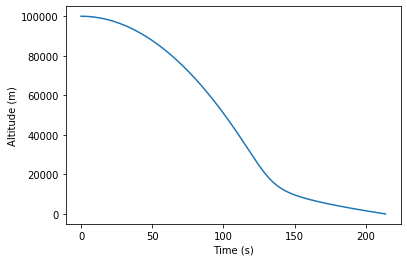

In [3]:
plt.plot(data['t'], data['h'])
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')

(100000, 0)

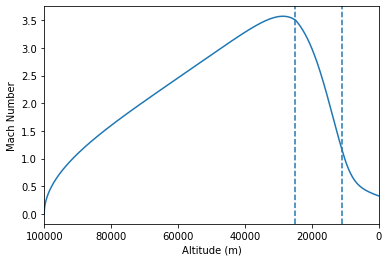

In [4]:
plt.plot(data['h'], data['mach'])
plt.axvline(x=11000, linestyle = '--')
plt.axvline(x=25000, linestyle = '--')
plt.xlabel('Altitude (m)')
plt.ylabel('Mach Number')
plt.xlim(100000, 0)

The two dashed lines mark the different sections of the atmosphere used in the NASA atmospheric model, with the left section on the plot in the upper stratosphere, then lower stratosphere, and then the troposphere. The skydiver appears to spend most of the time gaining in mach number (not necessarily speed as mach is also dependent upon speed of sound) right up until they hit the lower stratosphere and rapidly lose mach number going subsonic around the troposphere boundary where they begin to level off.

In [5]:
data.tail()

,t,h,u,Fd,c,mach
2134,213.4,37.993842,110.510734,940.408251,340.103291,0.324933
2135,213.5,26.949148,110.446936,940.318286,340.145663,0.324705
2136,213.6,15.910825,110.383237,940.228578,340.188006,0.324477
2137,213.7,4.878861,110.319638,940.139128,340.230318,0.324250
2138,213.8,-6.146753,110.256138,940.049933,340.272601,0.324023


At the end of the skydivers fall, they are going about 110 m/s, which is very fast for skydiving but within ranges of the fastest streamlined skydivers as described in [this article](https://en.wikipedia.org/wiki/Speed_skydiving). How did the speed and speed of sound change as they descended?

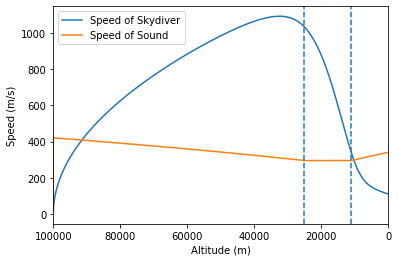

In [6]:
plt.plot(data['h'], data['u'], label='Speed of Skydiver')
plt.plot(data['h'], data['c'], label='Speed of Sound')
plt.axvline(x=11000, linestyle = '--')
plt.axvline(x=25000, linestyle = '--')
plt.xlabel('Altitude (m)')
plt.ylabel('Speed (m/s)')
plt.xlim(100000, 0)
plt.legend()

The speed of sound appears to change linearly in the upper stratosphere and troposphere. This is due to the atmospheric model used as the temperature changes linearly in both of these regemes, so the actual speed of sound is varying by the half power in these regions.

While these are interesting results, there are some things that could point to bad assumptions:
1. The fall only took a little over 3.5 minutes, which is very quick especially considering the distance fallen. Felix Baumgardner currently holds the record for the fastest free fall, falling from a distance of 38.6 km and reaching Mach 1.24. Granted, our skydiver is going much faster than that but I'm not sure if this time is realistic. The speed brings up the next point
2. Reaching Mach 3.5 is insane for a human in free fall. This was acheived due to the low density in the upper stratosphere, which Felix was on the lower portion of in his fall. However, this is likely an over-estimate as we greatly simplified and reduced the drag on the skydiver, so reaching this Mach number is likely impossible.

I hope this guide was helpful in understanding extreme free fall and how complicated things can get to calculate when going supersonic. If you would like to investigate this topic more, I would suggest looking into material that covers Gas Dynamics or Compressible Flows.